# Table of Contents
 <p><div class="lev1"><a href="#Question-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Question 1</a></div><div class="lev1"><a href="#Question-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Question 2</a></div><div class="lev1"><a href="#Question-4"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 4</a></div>

In [1]:
require(reshape)
require(ggplot2)
require(MASS)

Loading required package: reshape
Loading required package: ggplot2
Loading required package: MASS


With the inestimable help of Alexander Chan

# Question 1

(25pt + 10pt) In this question, we use the file `brader.csv` which contains data from Brader, Valentino and Suhay (2008). The file includes the following variables for $n=265$ observations:

* the outcome of interest -- a four-point scale in response to *Do you think the number of immigrants from foreign countries should be increased or decreased?*
* tone of the story treatment (positive or negative)
* ethnicity of the featured immigrant treatment (Mexican or Russian)
* respondents' age
* respondents' income


Consider the following ordered logit model for an ordered outcome variable with four levels:
        $$ \Pr(Y_i \leq j \mid X_i) \ = \ \frac{\exp(\psi_j - X_i^\top\beta)}
            {1 + \exp(\psi_j - X_i^\top\beta)} $$
for $j = 1,2,3,4$ and $i = 1,...,n$ where $\psi_4=\infty$ and $X_i = [{\tt tone}_i \ {\tt eth}_i \ {\tt ppage}_i \ {\tt ppincimp}_i]^\top$ (i.e. no intercept).



**a) (5pt)** Write down the likelihood function.


*To simplify the notation, the indices* $i,j,k$ *are used consistently,* $i$ *to iterate over the number of observations,*$j$ *to iterate over the number of outcomes, and* $k$ * to iterate over the predictors.*

The log-likelihood can be easily seen to be:

$$
l = 
\prod_{i=1}^n 
\frac{\exp(\psi_{Y_i} - X_i^\top\beta)}
     {1 + \exp(\psi_{Y_i} - X_i^\top\beta)} -
\frac{\exp(\psi_{Y_i-1} - X_i^\top\beta)}
     {1 + \exp(\psi_{Y_i-1} - X_i^\top\beta)}
$$

To simplify, from here on $\phi$ will be the inverse link function and $\phi'$ its derivative. This allows us to write the above expression in a more Matricial form as:

$$
\prod_{i=1}^n \sum_{j=1}^4
\tilde M_{i,j}
\phi\left(\psi_{j} - \sum_{k=1}^m X_{ik}\beta_k\right)
$$

where 

$$
\tilde M = MK =  M 
\begin{pmatrix}
  1 &  0 &  0 &  0\\
 -1 &  1 &  0 &  0\\
  0 & -1 &  1 &  0\\
  0 &  0 & -1 &  1\\
\end{pmatrix}
$$

And $M$ is the OneHot matrix for the $Y_i$, i.e. a matrix that has $n$ rows, and each row is the row vector with zeros everywhere but at the position $j$, where the the observed $Y$ is $Y_j$.  
Below, there is a function that computes $\tilde M$ in R:

In [2]:
compute_M = function (Y,m){
    
    #This is just a One Hot encoder:
    n = length(Y)
    M1 = t(matrix(rep(c(1:m),n),m))
    M2 = matrix(rep(c(Y),m),n)
    M = (M1==M2)+0
    
    #Create the matrix K
    K = diag(m+1)
    K = -K[1:m,]+K[2:(m+1),]
    K = K[1:m,1:m+1]
    
    #Return the product
    M%*%K
}

In practice, however, we are interested in the log-likelihood, which is:

$$
L = \sum_{i=1}^n \log \sum_{j=1}^4
\tilde M_{i,j}
\phi\left(\psi_{j} - \sum_{k=1}^m X_{ik}\beta_k\right)
$$

The notation is further simplified if we pre-comute the $\phi\left(\psi_{j} - \sum_{k=1}^m X_{ik}\beta_k\right)$ as $\phi_{ij}'$ (and the same for $\phi_{ij}'$.

Below there is a wrapper in `R` that automatically defines these quantities for our function, so that we can use them :

In [3]:
wrapper = function(expression){
    function(X,Y,beta,psi,
             phi = function(x){exp(x)/(1+exp(x))},
             dphi = function(x){exp(x)/(1+exp(x))**2})
    {
        psi = append(psi,10); #add the 'infinity'
        m = length(psi); #number of outcomes
        n = length(Y) #number of observatons
        M = compute_M(Y,m);
        
        # transform beta_j to beta_jk (as in part d)
        # whenever necessary
        if(length(beta) == ncol(X))
            beta2 = matrix(rep(beta,m),ncol=m,byrow=0)
        else beta2 = beta
            
        #Compute the linear combination inside `psi`
        linear =  - (X%*%beta2)
        origin =  matrix(rep(psi,n) ,nrow = n, byrow = 1)
        l = origin +  linear
        
         phix = phi(l);   phix[,m]=1; #impose the 'infinity'
        dphix = phi(l);  dphix[,m]=0; #impose the 'infinity'

        expression(X,Y,beta,psi,M,phix,dphix);
    }
}

Now we are ready to define the log-likelihood function immediately using the abstraction wrapper:

In [4]:
log_likelihood = wrapper(
    function(X,Y,beta,psi,M,phi,dphi){
        sum(log(rowSums(M*phi)))
    }
)

The wrapper function is just an abstaction (see it at the end of the file, in the annex), that computes the variables `M`, `phi`$=\phi\left(\psi_{j} - \sum_{k=1}^m X_{ik}\beta_k\right)$, `dphi`$=\phi'\left(\psi_{j} - \sum_{k=1}^m X_{ik}\beta_k\right)$. We use it because everything is easier in those variables. When a function goes trough the "wrapper", its arguments change to become (X,Y,beta,psi), and the wrapper computes M, phi and dphi.

b) (10pt) Derive the score functions for $\beta$ and $\psi_j$.


To simplify the computations, let $\phi_{ij}=\phi(\psi_{j} - X_i^\top\beta)$, and $\phi_{ij}'=\phi'(\psi_{j} - X_i^\top\beta)$. Then we will have:

$$
L = \sum_{i=1}^n \log \sum_{j=1}^4
\tilde M_{i,j}
\phi_{i,j}
$$




Since deriveatives and sums commute freely, we can compute the score easily:

$$
\frac{\partial L}{\partial \beta_k} = -
\sum_{i=1}^n \left (\sum_{j=0}^4 \tilde M_{i,j}\phi_{i,j} \right )^{-1}
\left (\sum_{j=0}^4
\tilde M_{i,j}\phi_{i,j}'\right )  X_{ik}
$$

in `R` that is:

In [5]:
beta_score =  wrapper(
    function(X,Y,beta,psi,M,phi,dphi){
        -(rowSums(M*dphi)/rowSums(M*phi))%*%X
    }
)

For the $\psi$, the result is equally immediate:

$$
\frac{\partial L}{\partial \psi_j} = 
\sum_{i=1}^n \left (\sum_{j=0}^4 \tilde M_{i,j}\phi_{i,j} \right )^{-1}
\tilde M_{i,j}\phi_{i,j}'
$$

which in `R` can be written as:

In [6]:
psi_score =  wrapper(
    function(X,Y,beta,psi,M,phi,dphi){
        r = (rowSums(M*phi)**-1%*%(M*dphi))
        r[1:(length(r)-1)]
    }
)


(10pt) Using (a) and (b), calculate the maximum likelihood estimates of $\beta$ and $\psi_j$ and their standard errors via the `optim` function in R. Confirm your results by comparing them to outputs from the `polr` function in the `MASS` package.

Load the data:

In [7]:
brader = read.csv('Data/brader.csv')

Prepare a Handler function for `optim`

In [8]:
likelihood_handler = function (x,data){
    X = data[[1]]
    Y = data[[2]]
    o = ncol(X)
    beta = x[1:o]
    psi = x[(o+1):length(x)]
    l = length(psi)
    diff_psi = psi[2:l]-psi[1:(l-1)]
    if(min(diff_psi)<=0)
        return (1E5)
        
        
    return(-log_likelihood(X,Y,beta,psi))
}

In [9]:
gradient_handler = function(x,data){
    X = data[[1]]
    Y = data[[2]]
    o = ncol(X)
    beta = x[1:o]
    psi = x[(o+1):length(x)]
    l = length(psi)
    diff_psi = psi[2:l]-psi[1:(l-1)]
    if(min(diff_psi)<=0)
        return(x*0);
    sbeta = (-beta_score(X,Y,beta,psi)) 
    spsi  = (-psi_score(X,Y,beta,psi)) 
    return(append(sbeta,spsi))
}

Then we prepare the data as our function needs it

In [10]:
Y = brader$immigr
X = data.matrix(brader)[,2:5]
data = list(X,Y)
beta = c(0.5, 0, 0, 0)
psi = c(-1, 0, 1)
betapsi = append(beta,psi)

And we run the optimization

In [11]:
r = optim(betapsi,likelihood_handler, gr = gradient_handler, data = data,
          hessian = 1, control = (reltol = 1E-12))
r$par
r$value

[1]  0.750574726  0.182514633  0.009542462  0.004538011 -1.649875236
[6]  0.153712693  1.374591446

[1] 325.9479

In [12]:
library(MASS)

plr <- polr( factor(immigr) ~ tone + eth + ppage + ppincimp, 
                   data = brader, method = "logistic", Hess = 1)
summary(plr)
-log_likelihood(X,Y,plr$coefficients,plr$z)

Call:
polr(formula = factor(immigr) ~ tone + eth + ppage + ppincimp, 
    data = brader, Hess = 1, method = "logistic")

Coefficients:
            Value Std. Error t value
tone     0.749446   0.230241  3.2550
eth      0.166225   0.227063  0.7321
ppage    0.009345   0.007131  1.3105
ppincimp 0.004149   0.029511  0.1406

Intercepts:
    Value   Std. Error t value
1|2 -1.6671  0.5664    -2.9434
2|3  0.1318  0.5401     0.2441
3|4  1.3535  0.5466     2.4761

Residual Deviance: 651.8892 
AIC: 665.8892 

[1] 325.9446


** d. (10pt)  Bonus question. ** The standard ordered logit model is sometimes called the  proportional odds model because it assumes the effect of $X_i$ is constant across levels on the odds ratio scale. One approach to relax this assumption is to allow the coefficients to vary across levels, i.e.,
        $$ \Pr(Y_i \leq j \mid X_i) \ = \ \frac{\exp(\psi_j - X_i^\top\beta_j)}
            {1 + \exp(\psi_j - X_i^\top\beta_j)} $$
for $j = 1,2,3,4$ and $i = 1,...,n$ where $\beta_4=0$ (i.e. the fourth group is a reference group), and $\psi_4=\infty$. For this model, derive the likelihood and score functions, and use `optim` to obtain the maximum likelihood estimates of $\beta_j$ and $\psi_j$ and their standard errors for the `brader` data.

A direct modification of the above exercise, substituting $\beta_k$ for $\beta_{k,j}$ works:
We will have:

$$
L = \sum_{i=1}^n \log \sum_{j=1}^4
\tilde M_{i,j}
\phi\left(\psi_{j} - \sum_{k=1}^m X_{ik}\beta_{kj}\right)
$$

therefore, since the formula is essentialy the same (and thanks to `R` not really caring much about the shape of the objects  -- which is nice!), the same `log_likelihood` coded above still works!

Since deriveatives and sums commute freely, we can compute the score easily:

$$
\frac{\partial L}{\partial \beta_{kj}} = -
\sum_{i=1}^n \left (\sum_{j=0}^4 \tilde M_{i,j}\phi_{i,j} \right )^{-1}
\tilde M_{i,j}\phi_{i,j}'  X_{ik}
$$

in this case we must modify the function, to create a new function:

In [ ]:
extra_beta_score = wrapper(
    function(X,Y,beta,psi,M,phi,dphi){
        #this corresponds to a matrix that has the same elements in every
        #row, and are the (sum **)^{-1} in the formula above
        M1 = matrix(rep(rowSums(M*phi),ncol(M)),ncol=ncol(M),byrow=0)
        -t(M*dphi/M1)%*%X
    }
)

For the $\psi$, the result is equally immediate:

$$
\frac{\partial L}{\partial \psi_j} = 
\sum_{i=1}^n \left (\sum_{j=0}^4 \tilde M_{i,j}\phi_{i,j} \right )^{-1}
\tilde M_{i,j}\phi_{i,j}'
$$

As for the likelihood, the same function does the job

# Question 2

(30 pt.) Understanding the basics of maximum likelihood makes it easier to learn a wide range of models. Here you will learn about a model not covered in class. The {\it tobit model} is often used to model a censored
outcome variable, where we only observe values of the outcome above a certain threshold $\tau$ while values below that threshold take on a single value, say 0. A classic example is labor market participation:  you only observe a worker's wage if their potential earnings is high enough to be over minimium wage or otherwise employable.

Consider the case where $\tau=0$. In this case, the model can be written as follows.
  \begin{eqnarray*}
    Y_i & = & \left\{ \begin{array}{ll}
                    Y_i^\ast & {\rm if} \quad Y_i^\ast > 0 \\
                    0 & {\rm if} \quad Y_i^\ast \le 0 \end{array} \right.
                    \quad {\rm where} \quad Y_i^\ast = X_i^\top \beta + \epsilon_i,
  \end{eqnarray*}
  where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$.  Note that $Y_i$
  is the observed outcome variable and $Y_i^\ast$ is the underlying
  latent variable, which is not (always) observable.


**a.**(10pt) Derive the likelihood and log-likelihood functions of the model for a simple random sample of size $N$.

We will (for a moment) forget that log-likelihood is in fact terribly ill posed for variables that are a mixture of a continuous and a discrete variable, and proceed as if we didn't know that:

We have that:

$$
P(Y^*_k > 0) = P(Y_k > 0) = \Phi\left(\frac{x^T\beta}{\sigma}\right)
$$

Moreover, when $Y_k>0$ 
$$
\rho(Y^*_k|Y^*_k>0) = \rho(Y_k|Y_k>0) = (P(Y_k>0))^{-1} \phi\left (\frac{x^T\beta-Y_k}{\sigma}\right )
$$

For the other case we have:

$$
P(Y_k = 0) = P(Y^*_k < 0) = 1-\Phi\left(\frac{x^T\beta}{\sigma}\right)
$$


Therefore the likelihood is

$$
L(Y_i) = 
\left\{
\begin{array}{lr}
        1-\Phi\left(\frac{X_i^T\beta}{\sigma}\right), &  Y = 0\\
        \phi\left (\frac{X_i^T\beta-Y_i}{\sigma}\right ), & Y > 0 \\
\end{array}
\right.
$$


We will pretend what we did above is right for the sake of te exercise, but a careful second look shows that we have brutaly mixed probabilities and probability densities in an almost non-sensical way. Moreover note that the density is not even continuous, so any attempt to apply any of the theorems done at class is not justified (at least in the way we did them at class)

**b.** (10pt) A natural quantity of interest for this model is the expected value of the
  outcome variable conditional on a set of predictor levels,
  i.e., $\E(Y_i \mid X_i=x)$.  Prove that the exact
  expression for this quantity is the following.
  \begin{equation*}
    \E(Y_i \mid X_i=x) =  \Phi\left(\frac{x^\top \beta}{\sigma}\right)x^\top\beta + \sigma \phi\left(\frac{x^\top \beta}{\sigma}\right),
  \end{equation*}
  where $\phi(\cdot)$ and $\Phi(\cdot)$ denote the PDF and CDF of a standard normal random variable, respectively. \\
  {\bf Hint:} You may find the following property of the standard normal PDF helpful:
  $\partial\phi(z)/\partial z = -z\cdot \phi(z)$.


The expectation can be computed as the following integral:

$$
E(Y_i) =\int_{0}^\infty  \frac{d}{dy} \Phi\left (\frac{X_i^T\beta-y}{\sigma}\right ) y dy 
$$

Where we neglected the case where $Y_i=0$

In order to compute it, we will perform a change of variables, with $z = \frac{X_i^T\beta-y}{\sigma}$


\begin{align*}
E(Y_i)=
\int_{-\infty}^{\frac{X_i^T\beta}{\sigma}}
      \frac{d}{dz} \Phi\left (z\right ) (X_i^T\beta - z\sigma)dy = &
%
%
\Phi\left(\frac{X_i^T\beta}{\sigma}\right)X_i^T\beta 
+ \sigma \int_{-\infty}^{\frac{X_i^T\beta}{\sigma}} -z \frac{d}{dz} \Phi(z) dz = \\ = &
\Phi\left(\frac{X_i^T\beta}{\sigma}\right)X_i^T\beta 
+ \sigma \int_{-\infty}^{\frac{X_i^T\beta}{\sigma}} \frac{d}{dz} \phi(z) dz = \\ = &
\Phi\left(\frac{X_i^T\beta}{\sigma}\right)X_i^T\beta 
+\sigma \phi\left(\frac{X_i^T\beta}{\sigma}\right)
\end{align*}


*c.* (10pt) Nielsen (2013, {\it ISQ}) investigates the impact of human rights violations on the flows of foreign aid from donor states to recipient states. The file {\tt nielsenaid.csv} contains a small subset of the original dataset and consists of the following variables measured for each donor-recipient dyad:


* `lneconaid` --- log of economic aid commitments in U.S. dollars in 2000
* `l.physint` ---  physical integrity violations index (e.g. toture) in 1999
* `l.polity2` --- Polity IV democracy score in 1999
* `l.lneconaid` --- one-year lagged value of `lneconaid`
* `l.lnrgdp` --- log GDP per capita in 1999 candidate
* `l.lnpop` -- log population in 1999
* `colony` --- indicator of former colony
* `recep` --- recipient country name degree
* `donor` --- donor country name



Fit the above tobit model, where
\begin{eqnarray*}
Y_i & = & {\tt lneconaid}, \\
X_i & = & [ { {\tt l.physint}, {\tt l.polity2}, {\tt l.lneconaid}, {\tt l.lnrgdp}, {\tt l.lnpop}, {\tt colony} } ]^\top,
\end{eqnarray*}
and estimate $E[Y_i \mid X_i=x]$ and its asymptotic 95\% confidence interval, where $x$ equals the medians for all predictors except {\tt colony}, and the mode for {\tt colony}. (For this question, you may ignore possible error correlation across observations, such as clustering. You may use a canned procedure to obtain the MLE of $\beta$ and $\sigma$ as well as their sampling variance matrix; but for {\bf extra credit}, calculate those via {\tt optim} on your own.)


(20 pt.) Consider a supervised learning problem in which you sample $Y_i$ and $X_i$ from $p(X,Y)$. You assume an additive noise model such that: $Y_i=f(X_i)+\epsilon_i$, and $E[\epsilon_i|X_i]=0$. We wish to come up with $\hat{f}(X)$ that is the best approximation to $f(X)$ in some sense.

**a** (8pt.) First choose your loss function, $L(Y_i,\hat f(X_i))$ to be squared loss. Show that the minimizer of this loss is found by choosing $\hat{f}(X_i)=E[Y_i|X_i]$. (It suffices to show this pointwise, i.e. conditional on a particular choice of $X$). 

Pointwise we have 
\begin{align*}
E(L[Y_i,\hat f(X_I))] = &
E[(Y_i-f(X_i))^2|X_I] =  \\ = &
E[(Y_i-\bar Y_i + \bar Y_i -\hat f(X_i))^2|X_I] =  \\ = &
E[(Y_i-\bar Y_i)^2+ ( \bar Y_i -\hat f(X_i))^2|X_I] =  \\ = &
E[(Y_i-\bar Y_i)^2|X_I] 
+ E[(\bar Y_i -\hat f(X_i))^2]
\end{align*}
 
 Of the two last summands, the first does not deppend on $\hat f$ and the seond is clearly minimized when $\hat{f}(X_i)=E[Y_i|X_i]$, as we wanted to prove. Note that we have used the property that for two intependent random variables $E[(X-Y)^2] = E[(\bar X -X)^2)+ E[(\bar X - Y)^2]$

**b.** (10pt.) Show that the expected generalization error, $\mathcal{R} = E[(Y_i-\hat{f}(X_i))^2]$, can be decomposed into an irreducible error, a bias term, and a variance term.  Furthermore, describe in plain English the meaning of variance and bias in this context. (Again, it suffices to do this pointwise, conditionally on $X$).

Using the previous result, we have:

\begin{align*}
E[(Y_i-f(X_i))^2] =  &
E[(Y_i-\bar Y_i)^2] 
+ E[(\bar Y_i -\hat f(X_i))^2] = \\ = &
E[(Y_i-\bar Y_i)^2] 
+ E[(\bar Y_i -E[\hat f(X_i)]+E[\hat f(X_i)]-\hat f(X_i))^2] = \\ = &
E[(Y_i-\bar Y_i)^2] 
+ E[(\bar Y_i -E[\hat f(X_i)])^2+(E[\hat f(X_i)]-\hat f(X_i))^2] = \\ = &
E[(Y_i-\bar Y_i)^2] 
+ E[(\bar Y_i -E[\hat f(X_i)])^2]+E[(E[\hat f(X_i)]-\hat f(X_i))^2]
\end{align*}

Where we have used (again) the same property of the expectations of squares of differences. THe first term is the irreducible error, the second therm is the bias term and the third term the variance term.

The variance term is the ineherent variance on the predictor function due to the fact that it is produced from random variables, the bias term is the perdiction error inherent to the learning algorithm, due to the fact that the real function cannot be totally understood by the predictor in some cases. It cannot be solved even by adding more data.

**c** (2pt.) In general how does a learning algorithm's flexibility relate to the bias and variance terms described above?

# Question 4

Cross Validation for Polynomial Regression. (18 points)
Consider the following four data generating processes:

* DGP 1: $Y = -2* 1_{\{X < -3\}} + 2.55* 1_{\{ X > -2\}} - 2* 1_{\{X>0\}} + 4* 1_{\{X > 2\}} -1* 1_{\{ X > 3\}}+ \epsilon$
* DGP 2: $Y = 6 + 0.4 X - 0.36X^2 + 0.005 X^3 + \epsilon$
* DGP 3: $Y = 2.83 * \sin(\frac{\pi}{2} \times X) +\epsilon $
* DGP 4: $Y = 4 * \sin(3 \pi \times X) * 1_{\{X>0\}}+ \epsilon$

  $X$ is drawn from the uniform distribution in [-4,4] and $\epsilon
  $
  is drawn from a standard normal ($\mu =0$, $\sigma^2$ = 1).

In [49]:
DGP1 = function(X){(
    -2   *(X < -3)
    +2.55*(X > -2)
    -2   *(X >  0)
    +4   *(X >  2)
    -1   *(X >  3))}
DGP2 = function(X){
    6+0.4*X-0.36*X^2+0.005*X^3
}
DGP3 = function(X){
    2.83*sin(pi/2*X)
}
DGP4 = function(X){
    4*sin(3*pi*X)*(X>0)
}
ERR = rnorm
DGP = c(DGP1,DGP2,DGP3,DGP4)

(5 pts.) Write a function to estimate the generalization error of a polynomial by $k$-fold cross-validation. It should take as arguments the data, the degree of the polynomial, and the number of folds $k$. It should return the cross-validation mean squared error.

In [29]:
genError = function(df,deg,k){
    n = nrow(df);
    sampler = sample(n)
    df = df[sampler,]
    folds = cut(seq(1,n),breaks=k,labels=FALSE)
    sse = 0;
    for(i in 1:k)
    {
        ind = which(folds==i,arr.ind=TRUE)
        test = df[ind,]
        train = df[-ind,]
        model = lm(Y ~ poly(X,deg), data = train)
        newY =  predict(model,test)
        sse = sse + sum((newY-test$Y)**2)
    }
    return(sse/n)
}

In [103]:
testCompare= function (interval_d,f,interval_i,n_times=10){
    h = function(N,D){
        r = 0;
        n = round(max(n_times,(n_times*1E2)/N+1))
        for(i in 1:n){
            X = 8*runif(N)-4
            Y = f(X)+ERR(X)
            df = data.frame(X,Y)
            r=r+genError(df,D,4)
        }
        r/n
    }
    r = sapply(interval_d,
           function(D){
               h2 = function(N){h(N,D)}
               sapply(interval_i,
                      h2)
           }
          )
    r = data.frame(r)
    colnames(r) = lapply(interval_d, 
                   function(x){paste('',toString(x),sep='')})
    r$x = interval_i
    r
}

In [104]:
make_the_plot=function(i){
    degrees = c(1:5)
    x = round(c(10*100^((0:20)/20)))
    r = testCompare(degrees,DGP[[i]],x)
    df = melt(r ,  id.vars = 'x')
    names(df) = c('Iterations', 'Degree','MSE')
    plot = ggplot(df, aes(Iterations,MSE))
    plot = plot + geom_line(aes(colour = Degree))
    plot = plot + scale_y_log10() + scale_x_log10() 
    plot
}

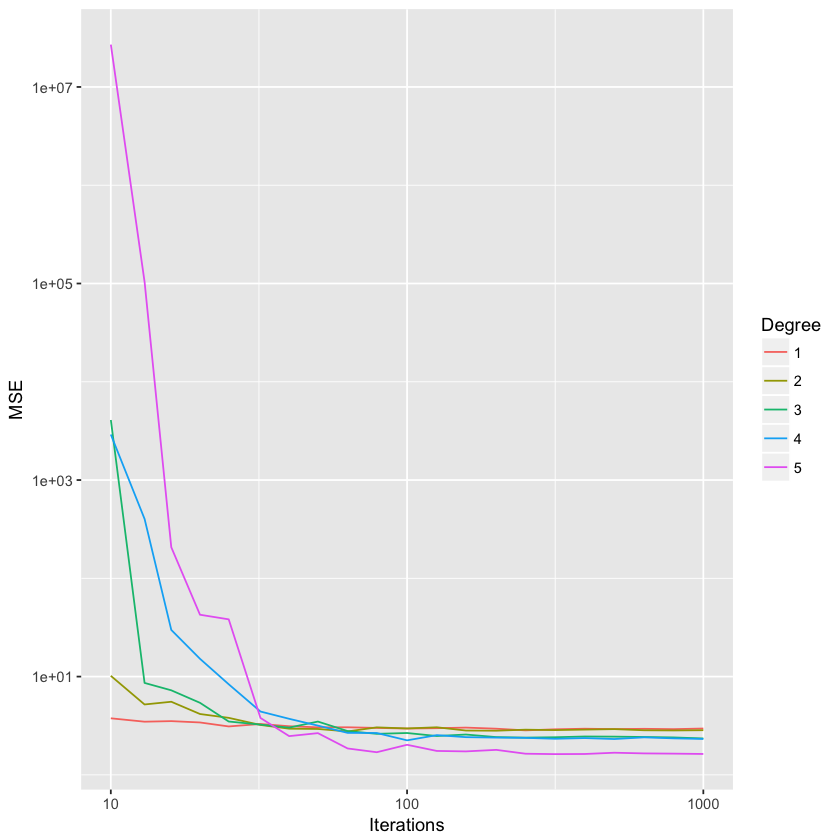

In [105]:
make_the_plot(1)

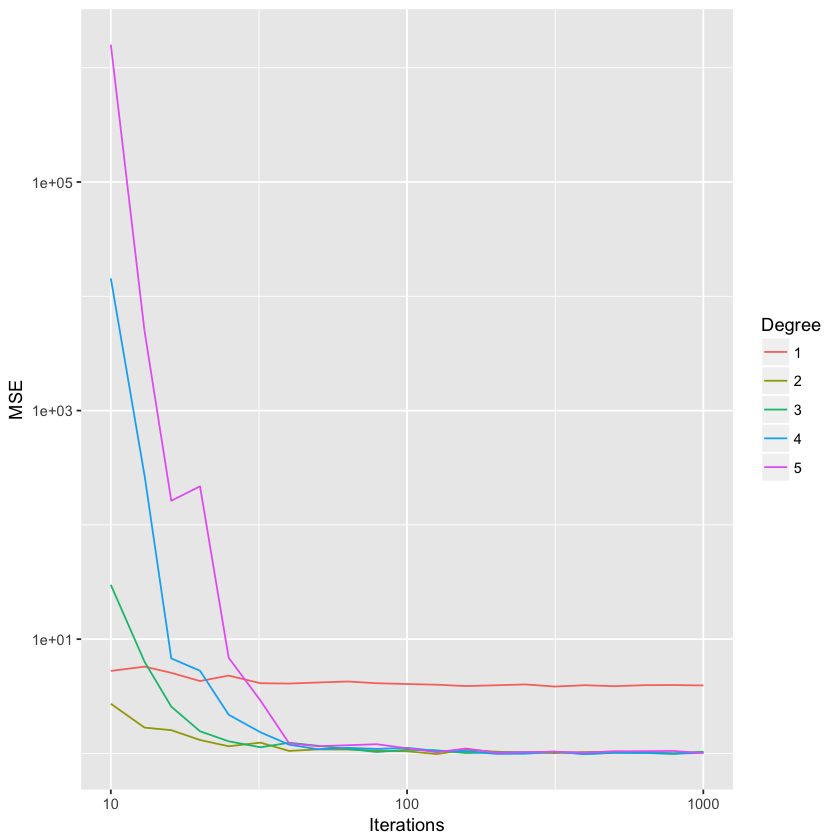

In [106]:
make_the_plot(2)

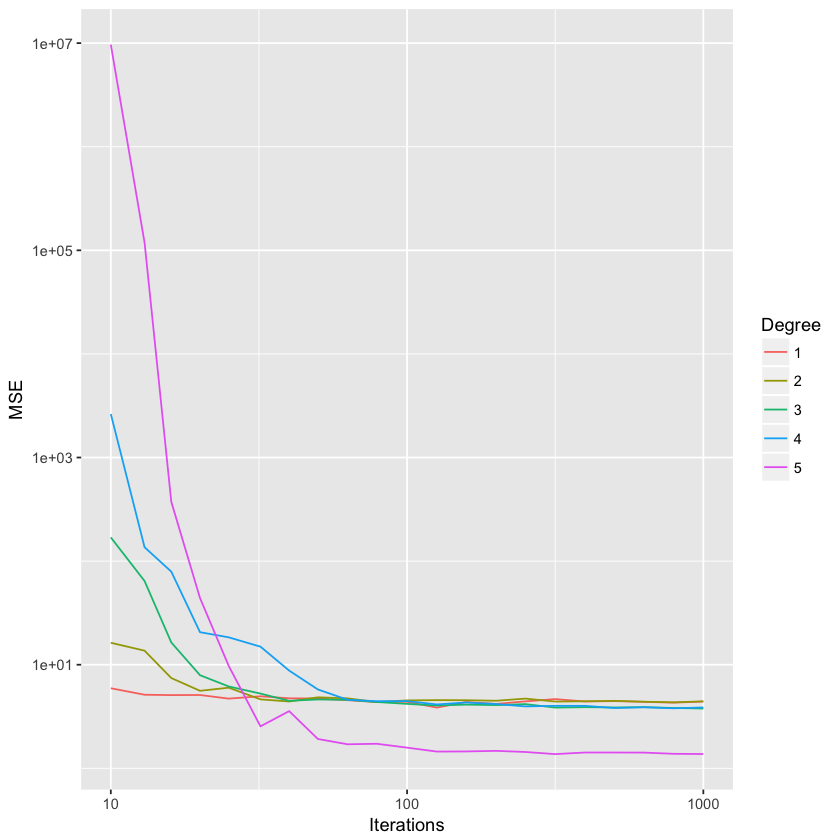

In [107]:
make_the_plot(3)

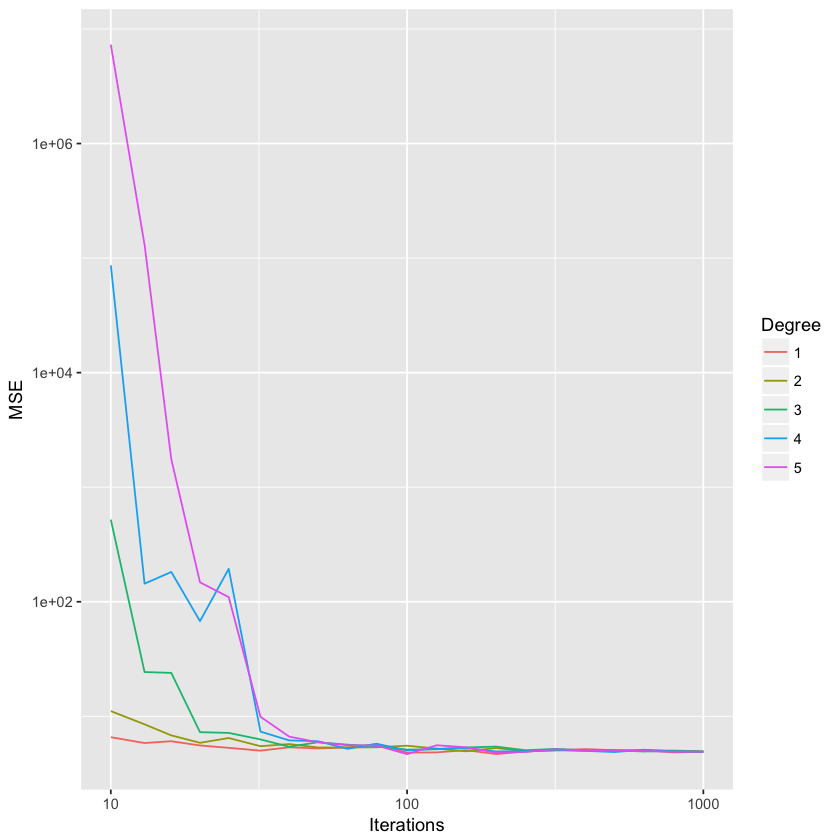

In [108]:
make_the_plot(4)

In [111]:
2**3

[1] 8